# Skin cancer detection:  Using a convolutional neural network Resnet50
 

Skin cancer is the most common human malignancy, is primarily diagnosed visually, beginning with an initial clinical screening and followed potentially by dermoscopic analysis, a biopsy and histopathological examination. Automated classification of skin lesions using images is a challenging task owing to the fine-grained variability in the appearance of skin lesions.

The dataset is taken from the ISIC (The International Skin Imaging Collaboration.) Archive. It consists of 1800 pictures of benign moles and 1497 pictures of malignant classified moles. The pictures have all been resized to low resolution (224x224x3) RGB. The task of this kernel is to create a model, which can classify a mole visually into benign and malignant.

As the dataset is pretty balanced, the model will be tested on the accuracy score, thus (TP + TN)/(ALL).

# Step 1 : importing Essential Libraries

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
np.random.seed(11) # It's my lucky number

import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

# Step 2 : Loading pictures and making Dictionary of images and labels
In this step I load in the pictures downloaded from ISIC (The International Skin Imaging Collaboration) and turn them into numpy arrays using their RGB values. As the pictures have already been resized to 224x224, there's no need to resize them. As the pictures do not have any labels, these need to be created. Finally, the pictures are added together to a big training set and shuffeled.

 In training set we have 1440 benign and 1197 malignant, so a total of 2637 images each of size 224x224x3
whereas in test set we have 360 benign and 300 malignant so that is a total of 660 images each of the size same as that of training images.


In [2]:
folder_benign_train = 'data/train/benign'
folder_malignant_train = 'data/train/malignant'

folder_benign_test = 'data/test/benign'
folder_malignant_test = 'data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]


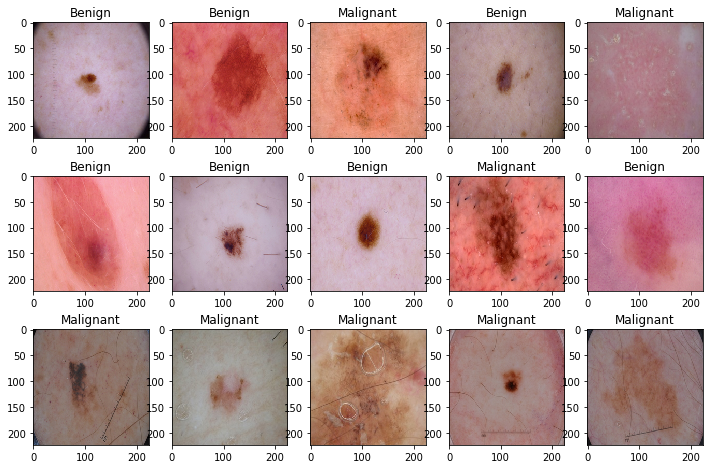

In [3]:
# Display first 15 images of moles, and how they are classified
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Step 3: Categorical Labels
Turn labels into one hot encoding

In [4]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [5]:
#printing the dimensions of X_train,y_train, X_test, y_test
print("dimensions of X_train :", X_train.shape)
print("dimensions of y_train :", y_train.shape)
print("dimensions of X_test :", X_test.shape)
print("dimensions of y_test :", y_test.shape)

dimensions of X_train : (2637, 224, 224, 3)
dimensions of y_train : (2637, 2)
dimensions of X_test : (660, 224, 224, 3)
dimensions of y_test : (660, 2)


# Step 4 : Normalization
Normalize all Values of the pictures by dividing all the RGB values by 255

In [6]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

# Step 5: Model Building 

#### The resnet50 model will be built using two type of blocks in between :
    1. The identity block
    2. The convolutional block
So, first of all i define the two functions for the two blocks separately and then will combine both of them to build our resnet50 model which will then be used for detecting skin cancer.

<a name='3-1'></a>
### 5.1 - The Identity Block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
    <caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 3 layers.</center></caption>
    
The upper path is the "shortcut path." The lower path is the "main path." In this diagram, their is a CONV2D and ReLU steps in each layer. To speed up training, a BatchNorm step has been added. 


In [7]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. This will be needed later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    
    # Final step: Adding shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X) 

    return X

<a name='3-2'></a>
### 5.2 - The Convolutional Block

The ResNet "convolutional block" is the second block type. This type of block is used when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>Convolutional block</b> </center></caption>


In [8]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # MAIN PATH
    # First component of main path glorot_uniform
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding='valid', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)
    
    #SHORTCUT PATH
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s,s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut) 
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

<a name='4'></a>  
## 5.3 - Building ResNet Model (50 layers)

Now with the necessary blocks we build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means a stack of 3 identity blocks together.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 5</b> </u><font color='purple'>  : <b>ResNet-50 model</b> </center></caption>

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - ReLU activation is applied.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

In [9]:
def ResNet50(input_shape = (224,224, 3), classes = 2):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape

    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
                    
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    
    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])  
    X = identity_block(X, 3, [512, 512, 2048])  

    # AVGPOOL.
    X = AveragePooling2D((2,2))(X) 
                    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [10]:
model = ResNet50(input_shape = (224,224,3), classes = 2)

In [11]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

# Step 6 : Training Model

Compile the model with adam optimizer and accuracy as the metrics. First train on 20 epochs with the training set and use the test set to check the accuracy after each epoch. Save the details in history, which will later be used to plot graphs.
After this, train the model on 50 epochs which can then be used for making predictions later.

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(X_train, y_train, epochs = 20, batch_size = 16, validation_data=(X_test, y_test))

Epoch 1/20
165/165 [==============================] - 842s 5s/step - loss: 1.7954 - accuracy: 0.6818 - val_loss: 0.7669 - val_accuracy: 0.7167
Epoch 2/20
165/165 [==============================] - 788s 5s/step - loss: 0.7174 - accuracy: 0.7524 - val_loss: 0.5820 - val_accuracy: 0.7727
Epoch 3/20
165/165 [==============================] - 751s 5s/step - loss: 0.5891 - accuracy: 0.7687 - val_loss: 0.9408 - val_accuracy: 0.6712
Epoch 4/20
165/165 [==============================] - 751s 5s/step - loss: 0.4932 - accuracy: 0.7808 - val_loss: 0.4195 - val_accuracy: 0.8000
Epoch 5/20
165/165 [==============================] - 751s 5s/step - loss: 0.4067 - accuracy: 0.8070 - val_loss: 0.3719 - val_accuracy: 0.8197
Epoch 6/20
165/165 [==============================] - 752s 5s/step - loss: 0.3753 - accuracy: 0.8157 - val_loss: 0.3689 - val_accuracy: 0.8227
Epoch 7/20
165/165 [==============================] - 755s 5s/step - loss: 0.3558 - accuracy: 0.8354 - val_loss: 0.4076 - val_accuracy: 0.7924

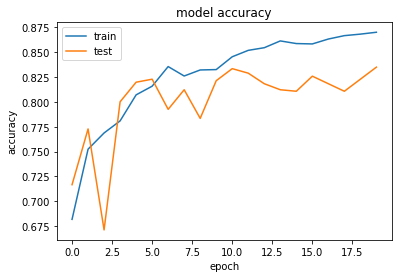

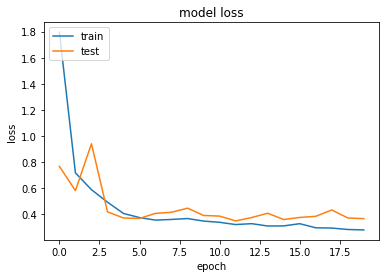

In [20]:
#Plotting graphs
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
#save this partially trained model to the disk
model.save('partially_trained_model.h5')
model.save('MyModel_tf',save_format='tf') 

c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: MyModel_tf\assets


c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [22]:
#Finally Train model on 50 epochs 
history2 = model.fit(X_train, y_train, epochs = 50, batch_size = 16)

Epoch 1/50
165/165 [==============================] - 713s 4s/step - loss: 0.2902 - accuracy: 0.8722
Epoch 2/50
165/165 [==============================] - 705s 4s/step - loss: 0.2790 - accuracy: 0.8733
Epoch 3/50
165/165 [==============================] - 705s 4s/step - loss: 0.2769 - accuracy: 0.8813
Epoch 4/50
165/165 [==============================] - 706s 4s/step - loss: 0.2602 - accuracy: 0.8893
Epoch 5/50
165/165 [==============================] - 706s 4s/step - loss: 0.2380 - accuracy: 0.8931
Epoch 6/50
165/165 [==============================] - 706s 4s/step - loss: 0.2165 - accuracy: 0.9037
Epoch 7/50
165/165 [==============================] - 707s 4s/step - loss: 0.2086 - accuracy: 0.9116
Epoch 8/50
165/165 [==============================] - 707s 4s/step - loss: 0.2220 - accuracy: 0.9067
Epoch 9/50
165/165 [==============================] - 706s 4s/step - loss: 0.2307 - accuracy: 0.8995
Epoch 10/50
165/165 [==============================] - 706s 4s/step - loss: 0.2002 - accura

# Step 7: Test the model
Now, its time to test our model's final accuracy on the previously unseen test dataset. 

In [23]:
#test the model on test set 
model.evaluate(X_test, y_test)

21/21 [==============================] - 54s 3s/step - loss: 0.8791 - accuracy: 0.8409


[0.8791302442550659, 0.8409090638160706]

So, we find that the final accuracy of our model is 98.94% on the training data whereas we get about 84.09% accuracy on the previously unseen test dataset which is quite good.

# Step 8: Save the model
Now, we save the model for the further predictions in all the three h5, tf and json formats

In [26]:
#save the model for further predictions 
model.save('trained_model.h5')

#to load back use
#temp = tf.keras.models.load_model('trained_model.h5')

#again saving as tf model
model.save('MyModelFinal_tf',save_format='tf') 
# loaded_model = tf.keras.models.load_model('./MyModel_tf')

# serialize model to JSON
resnet50_json = model.to_json()
with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)

# serialize weights to HDF5
model.save_weights("resnet50.h5")
print("Saved model to disk")

INFO:tensorflow:Assets written to: MyModelFinal_tf\assets


c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk


# Step 9: Test your own image

Class: 0
it is non cancerous


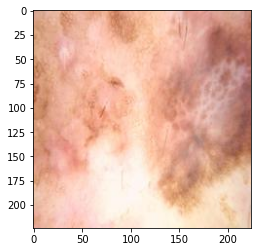

In [27]:
from tensorflow.keras.preprocessing import image
from matplotlib.pyplot import imshow
img_path = 'images/test_image.jpg'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
imshow(img)
prediction = model.predict(x)
print("Class:", np.argmax(prediction))
if np.argmax(prediction) == 0:
    print("it is non cancerous")
if np.argmax(prediction) == 1:
    print("it is cancerous")

# Biblography and references

1. Deeplearning specialization by Andrew Ng 
2. 
